In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from models import SRCNN_02 as model
from PIL import Image
import PIL.Image as pil_image
import torch.nn as nn
from utils import *


def SR(model,scale,file):
    device = torch.device("cpu")
    
    # load ground truth image
    image = pil_image.open(file).convert('RGB')
    image_width = (image.width // 12) * 12
    image_height = (image.height // 12) * 12
    image = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
    
    # input image blurred
    image = image.resize((image.width // scale, image.height // scale), resample=pil_image.BICUBIC)
    blurred_img = image.resize((image.width * scale, image.height * scale), resample=pil_image.BICUBIC)
    # blurred_img.save(args.image_file.replace('.', '_bicubic_x{}.'.format(scale)))

    blurred_img = np.array(blurred_img).astype(np.float32)
    ycbcr = convert_rgb_to_ycbcr(blurred_img)
    
    # extract luminance channel of a YCbCr image
    y = ycbcr[..., 0]
    y /= 255.
    y = torch.from_numpy(y).to(device)
    y = y.unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        y_pred = model(y)[1].clamp(0.0, 1.0)
    
    # compute score
    psnr = calc_psnr(y, y_pred)
    
    # process output
    y_pred = y_pred.mul(255.0).to(device).numpy().squeeze(0).squeeze(0)
    output = np.array([y_pred, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
    output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
    
    return blurred_img.astype(int), output.astype(int), psnr


def show_images(file, models, blur_scales, display, titles, show_scores, fontsize):
    imgs = [SR(models[i], blur_scales[i], file)[display[i]] for i in range(len(blur_scales))]  # show blurred inputs
    imgs = np.stack(imgs, axis=0)
    
    scores = [SR(models[i], blur_scales[i], file)[2] for i in range(len(blur_scales))]
    fig, axes = plt.subplots(1, len(blur_scales), figsize=(16, 6))

    for i, ax in enumerate(axes):
        ax.imshow(imgs[i], interpolation='none')
        ax.axis('off')
        title = f'{titles[i]}\n   PSNR: {scores[i]:.2f}' if show_scores[i] else f'{titles[i]}'
        ax.set_title(title, fontsize=fontsize)
    # plt.savefig(save_filename, dip=600)

## Reload SR models

In [2]:
finetuned_model_path = './finetuned_models_SR/'

model1 = model()
model2 = model()
model3 = model()

model1.load_state_dict(torch.load(os.path.join(finetuned_model_path, 'SRCNN_02_scale3to6_256samples_LVA.pth')))
model2.load_state_dict(torch.load(os.path.join(finetuned_model_path, 'SRCNN_02_scale3to6_256samples_grad.pth')))
model3.load_state_dict(torch.load(os.path.join(finetuned_model_path, 'SRCNN_02_scale3to6_16384samples_grad.pth')))

model1.eval()
model2.eval()
model3.eval()

SRCNN_02(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
)

## Blurred training inputs

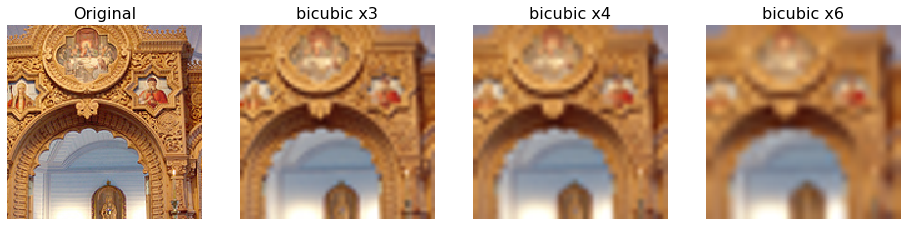

In [3]:
img = '../preprocessing_SR_images/CUFED/train_CUFED/ref/L_0_16185355@N00_11_0_48matches53_raw_01.png'

models = [model1, model1, model1, model1]
blur_scales=[1, 3, 4, 6]
input_or_predict = [0, 0, 0, 0]    # show "blurred input"=0, "model predict"=1
show_scores = [False, False, False, False]
titles = ['Original'] + [f'bicubic x{blur_scales[i]}' for i in range(1, len(blur_scales))]

show_images(img, models, blur_scales, input_or_predict, titles, show_scores, fontsize=16)

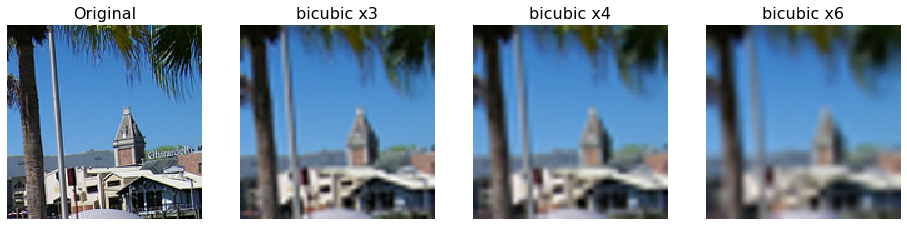

In [4]:
img = '../preprocessing_SR_images/CUFED/train_CUFED/ref/L_19_78672040@N00_00_0_50matches49_raw_02.png'

models = [model1, model1, model1, model1]
blur_scales=[1, 3, 4, 6]
input_or_predict = [0, 0, 0, 0]    # show "blurred input"=0, "predict"=1
show_scores = [False, False, False, False]
titles = ['Original'] + [f'bicubic x{blur_scales[i]}' for i in range(1, len(blur_scales))]

show_images(img, models, blur_scales, input_or_predict, titles, show_scores, fontsize=16)

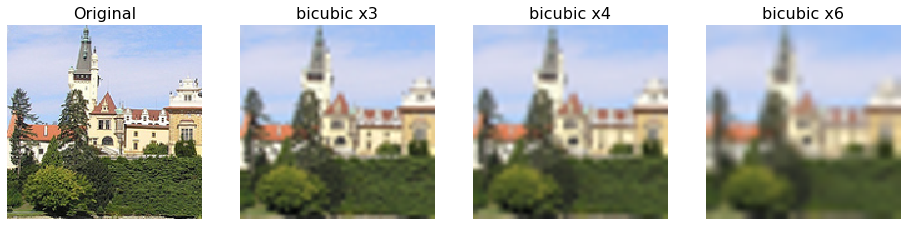

In [5]:
img = '../preprocessing_SR_images/CUFED/train_CUFED/ref/L_0_10779871@N00_06_0_55matches49_raw_03.png'

models = [model1, model1, model1, model1]
blur_scales=[1, 3, 4, 6]
input_or_predict = [0, 0, 0, 0]   # show "blurred input"=0, "model predict"=1
show_scores = [False, False, False, False]
titles = ['Original'] + [f'bicubic x{blur_scales[i]}' for i in range(1, len(blur_scales))]

show_images(img, models, blur_scales, input_or_predict, titles, show_scores, fontsize=16)

## Test deblur model on SET14 dataset

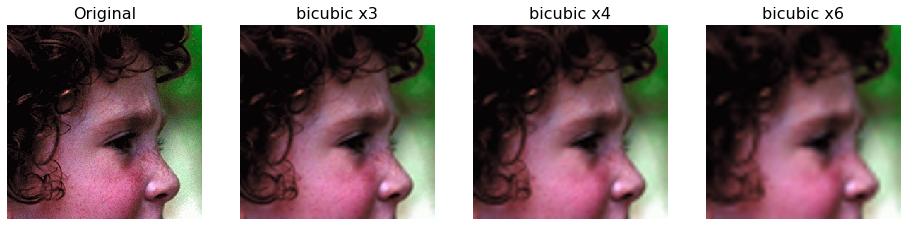

In [6]:
img = '../preprocessing_SR_images/Set14/face.png'

models = [model1, model1, model1, model1]
blur_scales=[1, 3, 4, 6]
input_or_predict = [0, 0, 0, 0]    # show "blurred input"=0, "model predict"=1
show_scores = [False, False, False, False]
titles = ['Original'] + [f'bicubic x{blur_scales[i]}' for i in range(1, len(blur_scales))]

show_images(img, models, blur_scales, input_or_predict, titles, show_scores, fontsize=16)

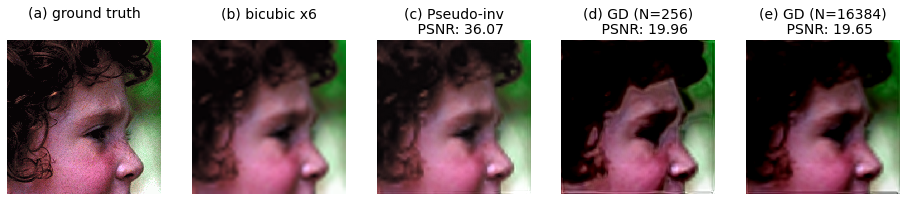

In [7]:
img = '../preprocessing_SR_images/Set14/face.png'

models = [model1, model1, model1, model2, model3]
blur_scales = [1, 6, 6, 6, 6]                   # show blurred images of blur scale
input_or_predict = [0, 0, 1, 1, 1]              # show "blurred input"=0, "model predict"=1
show_scores = [False, False, True, True, True]  # show pSNR scores
titles = ['(a) ground truth\n', '(b) bicubic x6\n', '(c) Pseudo-inv', '(d) GD (N=256)', '(e) GD (N=16384)']

show_images(img, models, blur_scales, input_or_predict, titles, show_scores, fontsize=14)

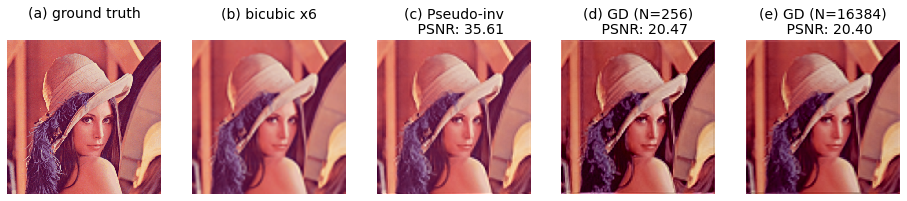

In [8]:
img = '../preprocessing_SR_images/Set14/lenna.png'

models = [model1, model1, model1, model2, model3]
blur_scales = [1, 6, 6, 6, 6]                   # show blurred images of blur scale
input_or_predict = [0, 0, 1, 1, 1]              # show "blurred input"=0, "model predict"=1
show_scores = [False, False, True, True, True]  # show pSNR scores
titles = ['(a) ground truth\n', '(b) bicubic x6\n', '(c) Pseudo-inv', '(d) GD (N=256)', '(e) GD (N=16384)']

show_images(img, models, blur_scales, input_or_predict, titles, show_scores, fontsize=14)

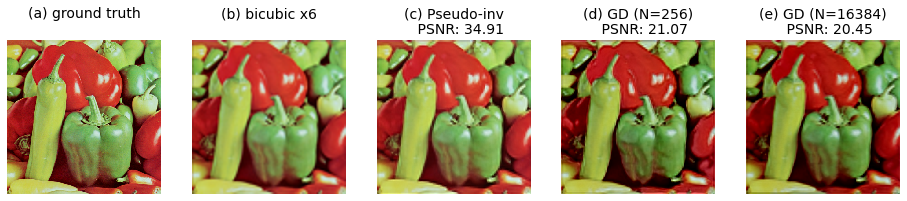

In [9]:
img = '../preprocessing_SR_images/Set14/pepper.png'

models = [model1, model1, model1, model2, model3]
blur_scales = [1, 6, 6, 6, 6]                   # show blurred images of blur scale
input_or_predict = [0, 0, 1, 1, 1]              # show "blurred input"=0, "model predict"=1
show_scores = [False, False, True, True, True]  # show pSNR scores
titles = ['(a) ground truth\n', '(b) bicubic x6\n', '(c) Pseudo-inv', '(d) GD (N=256)', '(e) GD (N=16384)']

show_images(img, models, blur_scales, input_or_predict, titles, show_scores, fontsize=14)